## Import Dataset Into Colab

In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving 2017_Toronto_Bikeshare (1).csv to 2017_Toronto_Bikeshare (1).csv
User uploaded file "2017_Toronto_Bikeshare (1).csv" with length 164192219 bytes


In [2]:
#Import Necessary Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
#Import dataset
df = pd.read_csv('2017_Toronto_Bikeshare (1).csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,4,6,7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## DATA DISCOVERY

In [4]:
#Sample data
df.sample(3)

,trip_id,trip_start_time,trip_stop_time,trip_duration_seconds,from_station_id,from_station_name,to_station_id,to_station_name,user_type
895289,1720032,8/31/2017 7:34,8/31/2017 7:42,503.0,Scott St / The Esplanade,Front St W / Blue Jays Way,Member,NaN,NaN
137051,874173,3/4/2017 17:10,3/4/2017 17:17,431.0,7077,College Park South,7014,Sherbourne St / Carlton St (Allan Gardens),Member
1038536,1874239,9/19/2017 12:23,9/19/2017 12:42,1182.0,Victoria St / Gould St (Ryerson University),College St / Crawford St,Member,NaN,NaN


In [5]:
# CHECK NUMBER OF ROWS AND COLUMNS
df.shape

(1492370, 9)

In [6]:
# Check for duplicates
df.duplicated().sum() #...No duplicates

0

In [7]:
#Check for duplicates based on unique Column
df[df.duplicated(['trip_id'])]  #No rows

,trip_id,trip_start_time,trip_stop_time,trip_duration_seconds,from_station_id,from_station_name,to_station_id,to_station_name,user_type


In [8]:
#check for NaN 
df.isnull().sum()  #....to_station_name and user_type have 1026894 NaN records each

trip_id                        0
trip_start_time                1
trip_stop_time                 1
trip_duration_seconds          1
from_station_id                1
from_station_name              2
to_station_id                  1
to_station_name          1026894
user_type                1026894
dtype: int64

## DATA CLEANSING AND MANIPULATION

In [0]:
#Drop Nan records for spicified columns
df.dropna(subset = ['trip_start_time','trip_stop_time','trip_duration_seconds','from_station_id','from_station_name','to_station_id'], inplace = True)

In [10]:
#QC Check
df.isnull().sum()

trip_id                        0
trip_start_time                0
trip_stop_time                 0
trip_duration_seconds          0
from_station_id                0
from_station_name              0
to_station_id                  0
to_station_name          1026892
user_type                1026892
dtype: int64

In [0]:
#convert data columns from object type to datetime
df['trip_start_time'] = pd.to_datetime(df['trip_start_time'], dayfirst = True) #----change from object type to datetime
df['trip_stop_time'] = pd.to_datetime(df['trip_stop_time'], dayfirst = True)  # ----change from object type to datetime

In [12]:
#QC Check
df.sample(2)

,trip_id,trip_start_time,trip_stop_time,trip_duration_seconds,from_station_id,from_station_name,to_station_id,to_station_name,user_type
867866,1690410,2017-08-27 14:27:00,2017-08-27 14:35:00,487.0,Victoria St / Gould St (Ryerson University),Princess St / Adelaide St E,Member,NaN,NaN
1423715,2301699,2017-11-28 19:16:14,2017-11-28 19:25:41,567.0,Nelson St / Duncan St,College Park South,Member,NaN,NaN


In [19]:
#Delete Records outside 2017 since Analysis is based on 2017 Data
print(df[df['trip_start_time'].dt.year != 2017].shape)
df[df['trip_start_time'].dt.year != 2017].head(3)

(160070, 9)


,trip_id,trip_start_time,trip_stop_time,trip_duration_seconds,from_station_id,from_station_name,to_station_id,to_station_name,user_type
1128964,1971685,2010-01-17,2010-01-17 00:14:00,849.0,Queen St W / James St,Taddle Creek Park,Member,NaN,NaN
1128965,1971686,2010-01-17,2010-01-17 00:00:00,26.0,Stewart St / Bathurst St - SMART,Stewart St / Bathurst St - SMART,Casual,NaN,NaN
1128966,1971687,2010-01-17,2010-01-17 00:22:00,1310.0,Hayter St / Laplante Ave,Queen St W / Portland St,Member,NaN,NaN


In [20]:
print(df[df['trip_start_time'].dt.year == 2017].shape)
df[df['trip_start_time'].dt.year == 2017].head(3)

(1332298, 9)


,trip_id,trip_start_time,trip_stop_time,trip_duration_seconds,from_station_id,from_station_name,to_station_id,to_station_name,user_type
0,712382,2017-01-01 00:00:00,2017-01-01 00:03:00,223.0,7051,Wellesley St E / Yonge St Green P,7089,Church St / Wood St,Member
1,712383,2017-01-01 00:00:00,2017-01-01 00:05:00,279.0,7143,Kendal Ave / Bernard Ave,7154,Bathurst Subway Station,Member
2,712384,2017-01-01 00:05:00,2017-01-01 00:29:00,1394.0,7113,Parliament St / Aberdeen Ave,7199,College St W / Markham St,Member


In [0]:
#delete non 2017 records
data = df[df['trip_start_time'].dt.year == 2017]

In [28]:
#QC check
data[df['trip_start_time'].dt.year != 2017]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,trip_id,trip_start_time,trip_stop_time,trip_duration_seconds,from_station_id,from_station_name,to_station_id,to_station_name,user_type


In [30]:
#Delete records with start time greater than stop time (Stop time should be greater)
print(data[data['trip_start_time'] > data['trip_stop_time']].shape)
data = data[data['trip_start_time'] < data['trip_stop_time']]

(333, 9)


In [31]:
#QC check
data[data['trip_start_time'] > data['trip_stop_time']]

,trip_id,trip_start_time,trip_stop_time,trip_duration_seconds,from_station_id,from_station_name,to_station_id,to_station_name,user_type


In [0]:
#Determine Overage
#Assumption (trip start and stop times are actual ride times trips lasted while trip duration is the booked time for the trips)
#Actual duration = trip_stop_time - trip_start_time
data['actual_Timedelta'] = data.trip_stop_time - data.trip_start_time
data['actual_days'] = data['actual_Timedelta'].dt.days
data['actual_seconds'] = data['actual_Timedelta'].dt.seconds
data['actual_duration'] = (data['actual_days'] * 24 * 60 * 60) + data['actual_seconds']

In [86]:
#QC Check
data.sample(3)

,trip_id,trip_start_time,trip_stop_time,trip_duration_seconds,from_station_id,from_station_name,to_station_id,to_station_name,user_type,booked_Timedelta,booked_days,booked_seconds,booked_duration,overage,overage_charges,trip_start_time_weekday,trip_stop_time_weekday,trip_start_time_month,trip_stop_time_month,Quarter,startday_of_month,actual_Timedelta,actual_days,actual_seconds,actual_duration
1125269,1967751,2017-09-30 14:13:00,2017-09-30 14:43:00,1808.0,Queen St E / Larchmount Ave,Metro Hall Plaza,Member,NaN,NaN,00:30:00,0,1800,1800,8.0,4,Saturday,Saturday,September,September,Q3,30,00:30:00,0,1800,1800
62292,786042,2017-02-17 13:56:00,2017-02-17 14:02:00,307.0,7035,Queen St W / Ossington Ave,7158,King St W / Stafford St,Member,00:06:00,0,360,360,-53.0,0,Friday,Friday,February,February,Q1,17,00:06:00,0,360,360
1244791,2098744,2017-10-19 17:56:07,2017-10-19 18:11:51,944.0,College St / Markham St,Michael Sweet Ave / St. Patrick St,Member,NaN,NaN,00:15:44,0,944,944,0.0,0,Thursday,Thursday,October,October,Q4,19,00:15:44,0,944,944


In [0]:
#overage = Actual_duration - Booked_duration
data['overage'] = data['actual_duration'] - data['trip_duration_seconds']

In [88]:
#QC Check
data.sample(3)

,trip_id,trip_start_time,trip_stop_time,trip_duration_seconds,from_station_id,from_station_name,to_station_id,to_station_name,user_type,booked_Timedelta,booked_days,booked_seconds,booked_duration,overage,overage_charges,trip_start_time_weekday,trip_stop_time_weekday,trip_start_time_month,trip_stop_time_month,Quarter,startday_of_month,actual_Timedelta,actual_days,actual_seconds,actual_duration
699856,1507905,2017-03-08 20:05:00,2017-03-08 20:06:00,53.0,Bay St / College St (East Side),Bay St / College St (East Side),Member,NaN,NaN,00:01:00,0,60,60,7.0,0,Wednesday,Wednesday,March,March,Q1,8,00:01:00,0,60,60
1089566,1929060,2017-09-25 16:56:00,2017-09-25 17:05:00,537.0,Bay St / Wellesley St W,King St W / Bay St (West Side),Member,NaN,NaN,00:09:00,0,540,540,3.0,0,Monday,Monday,September,September,Q3,25,00:09:00,0,540,540
1250694,2105303,2017-10-20 15:28:17,2017-10-20 15:28:44,27.0,Dundas St W / Yonge St,Dundas St W / Yonge St,Member,NaN,NaN,00:00:27,0,27,27,0.0,0,Friday,Friday,October,October,Q4,20,00:00:27,0,27,27


In [0]:
#Determine Overage Charges
#Overage price model
#Types of overage:       Charge per model
#Type 1  0-30 minutes --- 4 * 1
#Type 2  31-60 minutes -- 4 * 2
#Type 3  61-90 minutes -- 4 * 3
#Type 4  91-120 minutes - 4 * 4
#Type 5 120+ minutes ---- 4 * 5 """"

#Create a function to generate charges

def ov_charge(n):
#function to generate overage charges
  n = n/60
# n is time overage in seconds
  if n > 0 and n <= 30:
    return(int(4))
  elif n > 30 and n <= 60:
    return(int(4*2))
  elif n > 60 and n <= 90:
    return(int(4*3))
  elif n > 90 and n <= 120:
    return(int(4*4))
  elif n > 120:
    return(int(4*5))
  else:
    return(int(0))

In [90]:
#QC to check function works well
ov_charge(4000)

12

In [0]:
#Apply overage function on overage column
data['overage_charges'] = data['overage'].apply(ov_charge)

In [92]:
#QC Check
data.sample(3)

,trip_id,trip_start_time,trip_stop_time,trip_duration_seconds,from_station_id,from_station_name,to_station_id,to_station_name,user_type,booked_Timedelta,booked_days,booked_seconds,booked_duration,overage,overage_charges,trip_start_time_weekday,trip_stop_time_weekday,trip_start_time_month,trip_stop_time_month,Quarter,startday_of_month,actual_Timedelta,actual_days,actual_seconds,actual_duration
1313986,2175476,2017-10-31 20:10:12,2017-10-31 20:13:44,212.0,Jarvis St / Carlton St,Parliament St / Aberdeen Ave,Member,NaN,NaN,00:03:32,0,212,212,0.0,0,Tuesday,Tuesday,October,October,Q4,31,00:03:32,0,212,212
212977,960824,2017-05-02 11:24:00,2017-05-02 11:39:00,880.0,7208,80 Clinton St (North of College),7015,King St W / Bay St (West Side),Member,00:15:00,0,900,900,20.0,4,Tuesday,Tuesday,May,May,Q2,2,00:15:00,0,900,900
449240,1234333,2017-06-27 22:42:00,2017-06-27 22:55:00,790.0,7168,Queens Quay / Yonge St,7014,Sherbourne St / Carlton St (Allan Gardens),Member,00:13:00,0,780,780,-10.0,0,Tuesday,Tuesday,June,June,Q2,27,00:13:00,0,780,780


In [0]:
#Extracting Weekday from Dates
dayOfWeek={0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
data['trip_start_time_weekday'] = data['trip_start_time'].dt.dayofweek.map(dayOfWeek)
data['trip_stop_time_weekday'] = data['trip_stop_time'].dt.dayofweek.map(dayOfWeek)

In [94]:
#QC check
data.sample(3)

,trip_id,trip_start_time,trip_stop_time,trip_duration_seconds,from_station_id,from_station_name,to_station_id,to_station_name,user_type,booked_Timedelta,booked_days,booked_seconds,booked_duration,overage,overage_charges,trip_start_time_weekday,trip_stop_time_weekday,trip_start_time_month,trip_stop_time_month,Quarter,startday_of_month,actual_Timedelta,actual_days,actual_seconds,actual_duration
116776,851129,2017-03-23 17:31:00,2017-03-23 17:44:00,761.0,7198,Queen St W / Cowan Ave,7046,Niagara St / Richmond St W,Casual,00:13:00,0,780,780,19.0,4,Thursday,Thursday,March,March,Q1,23,00:13:00,0,780,780
1058661,1896117,2017-09-21 17:49:00,2017-09-21 17:59:00,594.0,Lower Spadina Ave / Lake Shore Blvd,Lower Spadina Ave / Lake Shore Blvd,Member,NaN,NaN,00:10:00,0,600,600,6.0,4,Thursday,Thursday,September,September,Q3,21,00:10:00,0,600,600
622572,1424502,2017-07-24 13:51:00,2017-07-24 14:16:00,1462.0,College St / Huron St,Elizabeth St / Edward St (Bus Terminal),Casual,NaN,NaN,00:25:00,0,1500,1500,38.0,4,Monday,Monday,July,July,Q3,24,00:25:00,0,1500,1500


In [0]:
#Extracting months of year from Dates
MonthofYear = {1:'January', 2:'February', 3:'March', 4:'April', 5:'May', 6:'June', 7:'July', 8:'August', 9:'September', 10:'October', 11:'November', 12:'December'}
data['trip_start_time_month'] = pd.DatetimeIndex(data['trip_start_time']).month.map(MonthofYear)
data['trip_stop_time_month'] = pd.DatetimeIndex(data['trip_stop_time']).month.map(MonthofYear)

In [96]:
#QC check
data.sample(2)

,trip_id,trip_start_time,trip_stop_time,trip_duration_seconds,from_station_id,from_station_name,to_station_id,to_station_name,user_type,booked_Timedelta,booked_days,booked_seconds,booked_duration,overage,overage_charges,trip_start_time_weekday,trip_stop_time_weekday,trip_start_time_month,trip_stop_time_month,Quarter,startday_of_month,actual_Timedelta,actual_days,actual_seconds,actual_duration
791042,1607561,2017-08-17 08:49:00,2017-08-17 09:10:00,1246.0,Church St / Bloor St E,King St W / Spadina Ave,Member,NaN,NaN,00:21:00,0,1260,1260,14.0,4,Thursday,Thursday,August,August,Q3,17,00:21:00,0,1260,1260
199132,945119,2017-04-26 22:20:00,2017-04-26 22:37:00,995.0,7068,Dockside Dr / Queens Quay E (Sugar Beach),7172,Strachan Ave / Princes' Blvd,Member,00:17:00,0,1020,1020,25.0,4,Wednesday,Wednesday,April,April,Q2,26,00:17:00,0,1020,1020


In [0]:
#Extracting Quarters from Dates
QuarterofYear = {1:'Q1', 2:'Q2', 3:'Q3', 4:'Q4'}
data['Quarter'] = data['trip_start_time'].dt.quarter.map(QuarterofYear)

In [98]:
#QC check
data.sample(2)

,trip_id,trip_start_time,trip_stop_time,trip_duration_seconds,from_station_id,from_station_name,to_station_id,to_station_name,user_type,booked_Timedelta,booked_days,booked_seconds,booked_duration,overage,overage_charges,trip_start_time_weekday,trip_stop_time_weekday,trip_start_time_month,trip_stop_time_month,Quarter,startday_of_month,actual_Timedelta,actual_days,actual_seconds,actual_duration
113564,847294,2017-03-21 21:47:00,2017-03-21 21:55:00,461.0,7074,Spadina Ave / Sussex Ave,7153,Bloor St W / Christie St,Member,00:08:00,0,480,480,19.0,4,Tuesday,Tuesday,March,March,Q1,21,00:08:00,0,480,480
593335,1392796,2017-07-19 18:59:00,2017-07-19 19:22:00,1412.0,25 York St (ACC/Union Station South),Ulster St / Bathurst St,Member,NaN,NaN,00:23:00,0,1380,1380,-32.0,0,Wednesday,Wednesday,July,July,Q3,19,00:23:00,0,1380,1380


In [0]:
#Extracting Day of the Month from Dates
data['startday_of_month'] = data['trip_start_time'].dt.day

In [100]:
#QC check
data.sample(2)

,trip_id,trip_start_time,trip_stop_time,trip_duration_seconds,from_station_id,from_station_name,to_station_id,to_station_name,user_type,booked_Timedelta,booked_days,booked_seconds,booked_duration,overage,overage_charges,trip_start_time_weekday,trip_stop_time_weekday,trip_start_time_month,trip_stop_time_month,Quarter,startday_of_month,actual_Timedelta,actual_days,actual_seconds,actual_duration
347032,1117627,2017-06-08 00:28:00,2017-06-08 00:41:00,788.0,7004,University Ave / Elm St,7040,Euclid Ave / Bloor St W,Member,00:13:00,0,780,780,-8.0,0,Thursday,Thursday,June,June,Q2,8,00:13:00,0,780,780
1062168,1899768,2017-09-22 08:15:00,2017-09-22 08:36:00,1268.0,Davenport Rd / Bathurst St,Wellington St W / Bay St,Member,NaN,NaN,00:21:00,0,1260,1260,-8.0,0,Friday,Friday,September,September,Q3,22,00:21:00,0,1260,1260


## DATA ANALYSIS

In [101]:
#DATA ANALYSIS
#Most popular weekdays by Quarter
data.groupby(['trip_start_time_weekday','trip_start_time_month'])['trip_duration_seconds'].count().unstack().sort_values(by = 'February', ascending = False)

trip_start_time_month,April,August,December,February,January,July,June,March,May,November,October,September
trip_start_time_weekday,,,,,,,,,,,,
Wednesday,12335,31925,5485,14505,7028,21032,30059,16721,22002,20594,13631,24914
Thursday,10275,20247,14021,14299,6693,17878,32345,15419,12058,20396,13586,29315
Tuesday,10136,29925,3499,12489,6254,14285,18623,13832,25142,22092,18683,16450
Friday,17645,15456,9142,6155,6931,26809,32979,8053,12729,9044,20964,30900
Monday,12066,28899,1795,5787,13886,19489,19638,7408,21902,12282,22919,15607
Saturday,15901,14528,10030,4229,8791,23474,20689,3322,12150,4330,18958,27633
Sunday,18314,21452,1641,3653,10344,23316,16195,3388,19911,4312,21371,14306


In [102]:
data.groupby(['trip_start_time_weekday','Quarter'])['trip_duration_seconds'].count().unstack().sort_values(by = 'Q1', ascending = False)

Quarter,Q1,Q2,Q3,Q4
trip_start_time_weekday,,,,
Wednesday,38254,64396,77871,39710
Thursday,36411,54678,67440,48003
Tuesday,32575,53901,60660,44274
Monday,27081,53606,63995,36996
Friday,21139,63353,73165,39150
Sunday,17385,54420,59074,27324
Saturday,16342,48740,65635,33318


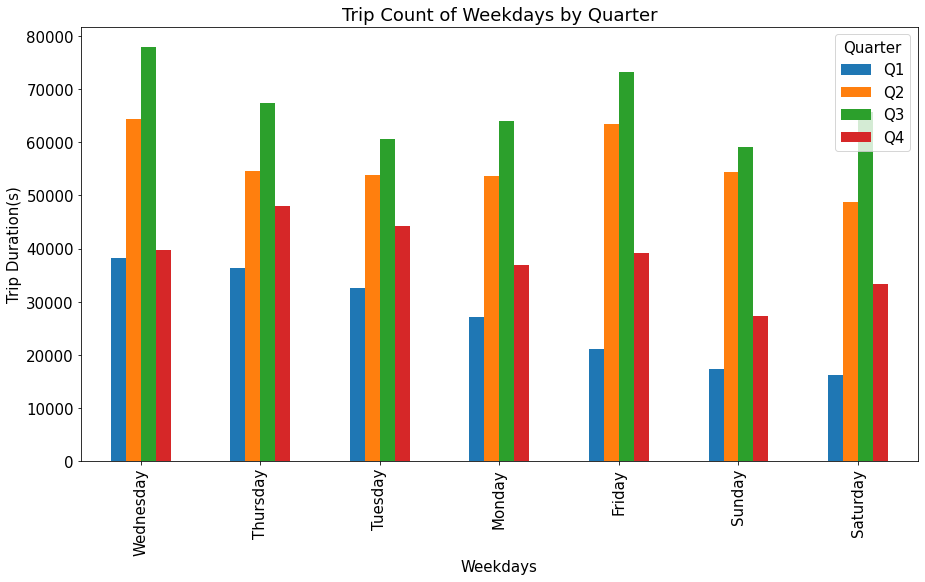

In [103]:
#Data Visualization
data.pivot_table(values ='trip_duration_seconds', columns = ['Quarter'], index = 'trip_start_time_weekday', aggfunc = 'count').sort_values(by ='Q1', ascending = False).plot.bar()
plt.title('Trip Count of Weekdays by Quarter')
plt.ylabel('Trip Duration(s)')
plt.xlabel('Weekdays')
from pylab import *
rcParams['figure.figsize'] = 15,8
plt.rcParams.update({'font.size': 15})

In [104]:
#Average ride time per day of the week, month --(startday_of_month,trip_start_time_weekday )
#Per Day of the Week
data.groupby(['trip_start_time_weekday'])[['booked_duration']].mean().sort_values(by = 'booked_duration', ascending = False).round(2)  #.head(4)

,booked_duration
trip_start_time_weekday,
Saturday,6286.36
Sunday,4468.26
Thursday,3732.22
Monday,3574.47
Tuesday,3196.21
Friday,2999.49
Wednesday,2976.41


In [105]:
#Average ride time per day of the week, month --(startday_of_month,trip_start_time_weekday )
#Per Day of the Month
data.groupby(['startday_of_month'])[['booked_duration']].mean().sort_values(by = 'booked_duration', ascending = False).round(2).head(4)

,booked_duration
startday_of_month,
7,16924.69
8,13866.09
9,11449.20
16,1195.56


Text(0.5, 0, 'Weekdays')

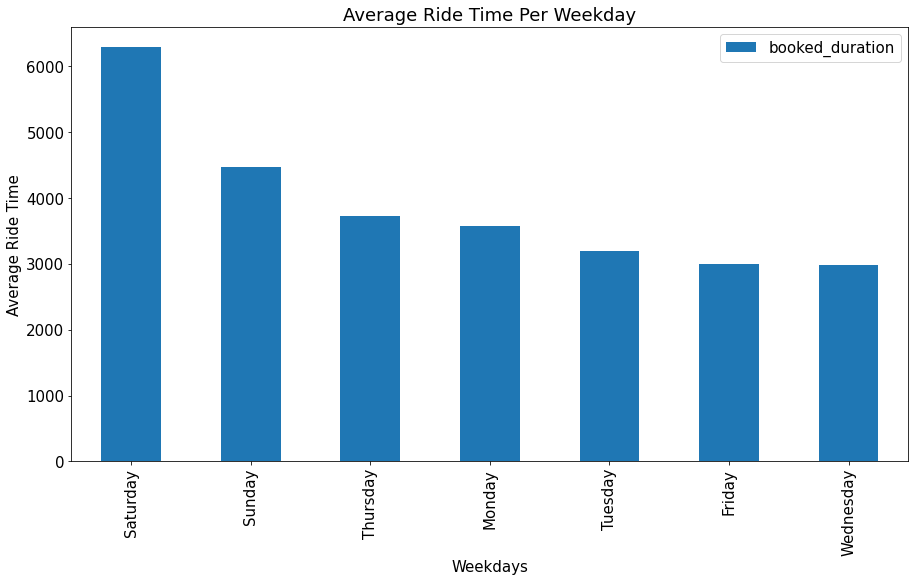

In [106]:
#Data Visualization
data.groupby(['trip_start_time_weekday'])[['booked_duration']].mean().sort_values(by = 'booked_duration', ascending = False).round(2).plot.bar()
plt.title('Average Ride Time Per Weekday')
plt.ylabel('Average Ride Time')
plt.xlabel('Weekdays')

In [0]:
#Average daily trips per month
data.groupby('trip_start_time_month').count()    #['trip_duration_seconds'].sum().mean()

In [107]:
#Get count of trips for each month, then divide by number of days per month for the average daily trips per month
Months = ['January','February','March','April','May','June','July','August','September','October','November','December']
trips_per_months = []
for month in Months:
  if month == Months[1]:
    trips_per_months.append(data[data['trip_start_time_month'] == month].shape[0] /28)
  elif month in ['April','June','November']:
    trips_per_months.append(data[data['trip_start_time_month'] == month].shape[0] /30)
  else:
    trips_per_months.append(data[data['trip_start_time_month'] == month].shape[0] /31)
for month, average in zip(Months, trips_per_months):
  print(f'Average daily trips for {month} is {average}')

Average daily trips for January is 1933.1290322580646
Average daily trips for February is 2182.75
Average daily trips for March is 2198.1612903225805
Average daily trips for April is 3222.4
Average daily trips for May is 4061.0967741935483
Average daily trips for June is 5684.266666666666
Average daily trips for July is 4718.806451612903
Average daily trips for August is 5239.741935483871
Average daily trips for September is 5133.064516129032
Average daily trips for October is 4197.1612903225805
Average daily trips for November is 3101.6666666666665
Average daily trips for December is 1471.3870967741937


In [109]:
#Popular start stations 
data['from_station_name'].value_counts()

Union Station                                 23139
Simcoe St / Wellington St W                   19255
York St / Queens Quay W                       18184
King St W / Spadina Ave                       17032
Queen St W / Portland St                      15583
                                              ...  
Dufferin Gate - SMART                           203
Victoria Park Subway Station - SMART            143
Summerhill Ave / MacLennan Ave - SMART          131
Dundas St W / Roncesvalles Green P - SMART      108
Fringe Next Stage - 7219                         29
Name: from_station_name, Length: 292, dtype: int64

In [110]:
#Popular start stations 
data['to_station_name'].value_counts()

Union Station                              9989
Simcoe St / Wellington St W                8068
Dundas St / Yonge St                       7443
King St W / Spadina Ave                    7395
Princess St / Adelaide St                  6685
                                           ... 
Danforth Ave / Barrington Ave               189
Lansdowne Ave / Whytock Ave                 176
Stephenson Ave / Main St                    164
Danforth Ave / Westlake Ave                 126
Woodbine Subway Green P (Cedarvale Ave)     122
Name: to_station_name, Length: 200, dtype: int64

In [111]:
#Total Overage trips
data[data['overage'] > 0].shape[0]

554424

In [112]:
#Money made from overage
data['overage_charges'].sum()

2240032

In [113]:
#show by type and member/non member (Note that User_type column has a lot of NaN values as such money made for such records cannot be directly calculated)
data.groupby('user_type')['overage_charges'].sum()

user_type
Casual    153348
Member    762408
Name: overage_charges, dtype: int64

In [114]:
#By Type
data.groupby(['overage_charges'])['overage_charges'].sum()

overage_charges
0           0
4     2212112
20      27920
Name: overage_charges, dtype: int64

#Types of overage: 
Type 1  0-30 minutes  --> 2212112

Type 2  31-60 minutes --> 0.00

Type 3  61-90 minutes --> 0.00

Type 4  91-120 minutes -> 0.00

Type 5 120+ minutes ----> 27920